In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import backtrader as bt
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import matplotlib.pylab as pylab
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.utils import np_utils

pylab.rcParams['figure.figsize'] = 40, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "40"

/home/project/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Starting Portfolio Value: 100000.00
2013-04-30, Close, 1597.57 ; Position 0.000000
2013-05-01, Close, 1582.70 ; Position 0.000000
2013-05-02, Close, 1597.59 ; Position 0.000000
2013-05-03, Close, 1614.42 ; Position 0.000000
2013-05-03, SELL CREATE, 1614.42
2013-05-06, SELL EXECUTED, 1614.40
2013-05-06, Close, 1617.50 ; Position -1.000000
2013-05-07, Close, 1625.96 ; Position -1.000000
2013-05-08, Close, 1632.69 ; Position -1.000000
2013-05-09, Close, 1626.67 ; Position -1.000000
2013-05-10, Close, 1633.70 ; Position -1.000000
2013-05-13, Close, 1633.77 ; Position -1.000000
2013-05-14, Close, 1650.34 ; Position -1.000000
2013-05-15, Close, 1658.78 ; Position -1.000000
2013-05-16, Close, 1650.47 ; Position -1.000000
2013-05-17, Close, 1667.47 ; Position -1.000000
2013-05-20, Close, 1666.29 ; Position -1.000000
2013-05-20, [Exit]BUY CREATE, 1666.29
2013-05-21, BUY EXECUTED, 1666.20
2013-05-21, Close, 1669.16 ; Position 0.000000
2013-05-22, Close, 1655.35 ; Position 0.000000
2013-05-22, SE

/home/project/workspace/backtrader/backtrader/plot/__init__.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/project/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/project/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/project/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/project/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/project/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    s

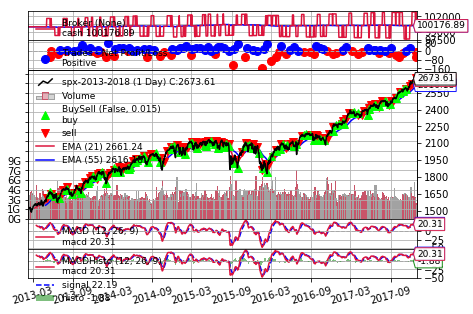

In [2]:
from backtrader.indicators import EMA
price = []
ema_55 = []
ema_21 = []
macd = []
histo = []
signal = []
class MomentumStrategy(bt.Strategy):
    params = (('histo', bt.indicators.MACDHisto),
             ('ema', bt.indicators.EMA))
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        self.order = None
        
        self.macd = bt.indicators.MACD(self.data,
                                       period_me1=12,
                                       period_me2=26,
                                       period_signal=9)
        
        self.histo = self.macd.macd - self.macd.signal
        self.hist = bt.indicators.MACDHisto(self.datas[0])
        self.ema_21 = self.params.ema(self.datas[0], period = 21)
        self.ema_55 = self.params.ema(self.datas[0], period = 55)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
       
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
    def next(self):
        histo.append(self.histo[0])
        price.append(self.dataclose[0])
        ema_55.append(self.ema_55[0])
        ema_21.append(self.ema_21[0])
        macd.append(self.macd.macd[0])
        signal.append(self.macd.signal[0])
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))
  
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        # Check if we are in the market
        if not self.position:
            #Open position
            
            # Not yet ... we MIGHT BUY if ...
            if np.all(self.histo.get(ago=0, size=3) > self.histo.get(ago=-1, size=3)) and self.histo[0] < 0: 
                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                #print (self.histo.get(ago=-1, size=3))
                #print (self.histo.get(ago=0, size=3))
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

            if np.all(self.histo.get(ago=0, size=3) < self.histo.get(ago=-1, size=3)) and self.histo[0] > 0:
                    
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                #print (self.histo.get(ago=-1, size=3))
                #print (self.histo.get(ago=0, size=3))
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
 
        #Exit position
        elif self.position.size>0:
            #Exit the long position
            if self.histo[0] > 0  or len(self) >= (self.bar_executed + 10):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                
        elif self.position.size<0:
            #Exit the short position
            if self.histo[0] < 0 or len(self) >= (self.bar_executed + 10):
            
                self.log('[Exit]BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
        

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(MomentumStrategy)

    datapath = os.path.join('../../../datas/spx-2013-2018.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2013, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2018, 1, 1),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Write output
    cerebro.addwriter(bt.WriterFile, out='momentum.csv',csv=True)
    
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot()




In [3]:
import pandas as pd

In [4]:
cross = list(np.array(ema_21) - np.array(ema_55))
initial_indicators = [price, ema_55, ema_21, cross, macd, signal, histo]
initial_indicators = pd.DataFrame(initial_indicators).T
initial_indicators.columns =  ['price','ema_55','ema_21', 'cross', 'macd','signal','histo']
initial_indicators.price = initial_indicators.price.diff()
initial_indicators.ema_21 = initial_indicators.ema_21.diff()
initial_indicators.ema_55 = initial_indicators.ema_55.diff()
initial_indicators.macd = initial_indicators.macd.diff()
initial_indicators.signal = initial_indicators.signal.diff()
initial_indicators.price[initial_indicators.price > 0] = 1
initial_indicators.price[initial_indicators.price <= 0] = 0
initial_indicators = initial_indicators[1:]
initial_indicators.head(10)

,price,ema_55,ema_21,cross,macd,signal,histo
1,0.0,1.170234,0.980442,21.791892,-0.393922,0.305055,1.220221
2,1.0,1.660225,2.244947,22.376614,0.770532,0.398151,1.592603
3,1.0,2.202003,3.570861,23.745472,1.828832,0.684287,2.737148
4,1.0,2.233360,3.526237,25.038349,1.540276,0.855485,3.421939
5,1.0,2.455740,3.974761,26.557371,1.725820,1.029552,4.118207
6,1.0,2.608392,4.225237,28.174216,1.713516,1.166345,4.665378
7,0.0,2.300235,3.293852,29.167833,0.667255,1.066527,4.266107
8,1.0,2.469156,3.633502,30.332179,0.880957,1.029413,4.117651
9,1.0,2.383471,3.309547,31.258255,0.483134,0.920157,3.680628
10,1.0,2.890133,4.515043,32.883165,1.482182,1.032562,4.130248


In [5]:
length = len(initial_indicators)
# divide into 6 parts
combi = np.arange(0, length, int(length/6))
data = []
for i in range(len(combi)-1):
    data.append(initial_indicators.iloc[combi[i]:combi[i+1]])
    print (len(initial_indicators.iloc[combi[i]:combi[i+1]]))

196
196
196
196
196
196


In [6]:
def scale(train, test):
    # fit scaler
    a,b,c = train.shape
    train = train.reshape(a * b, c)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    #train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    train_scaled = train_scaled.reshape(a,b,c)
    # transform test
    e,f,g = test.shape
    test = test.reshape(e * f, g)
    test_scaled = scaler.transform(test)
    test_scaled = test_scaled.reshape(e,f,g)
    print (train_scaled.shape)
    print (test_scaled.shape)
    return scaler, train_scaled, test_scaled

In [7]:
len(data)

6

In [8]:
for i in range(len(data)-5):
    item = data[i]
    ratio = .9
    offset = 5
    # past 6 days

    features = []
    labels = []

    item.index = np.arange(len(item))

    for i in range(offset, len(item)-1):
        feature = item.loc[i-offset:i,:].values
        features.append(feature)
        label = item.loc[i+1,'price']
        labels.append(label)
        
    train_len = int (len(labels) * ratio)
    train_x = np.array(features[:train_len])
    train_y = np_utils.to_categorical(np.array(labels[:train_len]))
    test_x_1 = np.array(features[train_len+1:])
    test_y_1 = np_utils.to_categorical(np.array(labels[train_len+1:]))


    _, train_x_scale, test_x_scale= scale(train_x, test_x)
    #train_y = np.reshape(train_y, (train_y.shape[0], 1))
    #test_y = np.reshape(test_y, (test_y.shape[0], 1))
    model1 = Sequential()
    model1.add(LSTM(32, input_shape=(6,7), return_sequences=False, stateful=False))
    model1.add(Dropout(0.2))
    model1.add(Dense(train_y.shape[1], activation='softmax'))
    model1.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    model1.fit(train_x, train_y,  batch_size=16,  epochs=50)
    print (model1.evaluate(test_x_1, test_y_1, batch_size=16))

(171, 6, 7)
(18, 6, 7)
Epoch 1/50
171/171 [==============================] - 1s 5ms/step - loss: 0.7373 - acc: 0.5497
Epoch 2/50
171/171 [==============================] - 0s 482us/step - loss: 0.6985 - acc: 0.5731
Epoch 3/50
171/171 [==============================] - 0s 527us/step - loss: 0.6925 - acc: 0.5848
Epoch 4/50
171/171 [==============================] - 0s 536us/step - loss: 0.6811 - acc: 0.6023
Epoch 5/50
171/171 [==============================] - 0s 518us/step - loss: 0.6826 - acc: 0.5673
Epoch 6/50
171/171 [==============================] - 0s 484us/step - loss: 0.6436 - acc: 0.6082
Epoch 7/50
171/171 [==============================] - 0s 504us/step - loss: 0.6736 - acc: 0.6374
Epoch 8/50
171/171 [==============================] - 0s 502us/step - loss: 0.6501 - acc: 0.6082
Epoch 9/50
171/171 [==============================] - 0s 605us/step - loss: 0.6466 - acc: 0.6491
Epoch 10/50
171/171 [==============================] - 0s 563us/step - loss: 0.6528 - acc: 0.6199
Epoch 11

In [9]:
price_diff = np.diff(price)
price_diff = np.r_[price_diff,[0]]
price_diff[price_diff > 0] = 1
price_diff[price_diff < 0] = 0

ema_diff = np.array(ema_21) - np.array(ema_55)

In [10]:
indicator = [price_diff, ema_diff, macd, histo, signal]
price
for i in indicator:
    print (len(i))

1178
1178
1178
1178
1178


In [11]:
indicators = pd.DataFrame(indicator).T

In [12]:
indicators.columns = ['price_diff','ema_diff','macd','hist','signal']
indicators.tail(10)

,price_diff,ema_diff,macd,hist,signal
1168,1.0,42.395196,22.300033,1.989046,20.310987
1169,0.0,44.039470,24.015064,2.963261,21.051802
1170,0.0,44.858251,24.391853,2.672041,21.719813
1171,1.0,45.307838,24.231995,2.009746,22.222249
1172,0.0,45.848489,24.254989,1.626192,22.628797
1173,0.0,46.105688,23.898475,1.015742,22.882733
1174,1.0,46.024708,23.120255,0.190018,22.930237
1175,1.0,45.921301,22.416176,-0.411249,22.827425
1176,0.0,45.953115,22.001571,-0.660683,22.662254
1177,0.0,45.062942,20.314783,-1.877977,22.192760


In [13]:
length = len(indicators)
# divide into 6 parts
combi = np.arange(0, length, int(length/6))
data = []
for i in range(len(combi)-1):
    data.append(indicators.iloc[combi[i]:combi[i+1]])
    print (len(indicators.iloc[combi[i]:combi[i+1]]))

196
196
196
196
196
196


In [14]:
def scale(train, test):
    # fit scaler
    a,b,c = train.shape
    train = train.reshape(a * b, c)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    #train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    train_scaled = train_scaled.reshape(a,b,c)
    # transform test
    e,f,g = test.shape
    test = test.reshape(e * f, g)
    test_scaled = scaler.transform(test)
    test_scaled = test_scaled.reshape(e,f,g)
    print (train_scaled.shape)
    print (test_scaled.shape)
    return scaler, train_scaled, test_scaled

In [15]:
for i in range(len(data)-5):
    item = data[i]
    ratio = .9
    offset = 5
    # past 6 days

    features = []
    labels = []

    item.index = np.arange(len(item))

    for i in range(offset, len(item)):
        feature = item.loc[i-offset:i,'ema_diff':'signal'].values
        features.append(feature)
        label = item.loc[i,'price_diff']
        labels.append(label)
        
    train_len = int (len(labels) * ratio)
    train_x = np.array(features[:train_len])
    train_y = np_utils.to_categorical(np.array(labels[:train_len]))
    test_x_2 = np.array(features[train_len+1:])
    test_y_2 = np_utils.to_categorical(np.array(labels[train_len+1:]))


    _, train_x_scale, test_x_scale= scale(train_x, test_x)
    #train_y = np.reshape(train_y, (train_y.shape[0], 1))
    #test_y = np.reshape(test_y, (test_y.shape[0], 1))
    model2 = Sequential()
    model2.add(LSTM(32, input_shape=(6,4), return_sequences=False, stateful=False))
    model2.add(Dropout(0.2))
    model2.add(Dense(train_y.shape[1], activation='softmax'))
    model2.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    model2.fit(train_x, train_y,  batch_size=16,  epochs=50)
                 
    print (model2.evaluate(test_x_2, test_y_2, batch_size=16))

(171, 6, 4)
(19, 6, 4)
Epoch 1/50
171/171 [==============================] - 1s 5ms/step - loss: 0.7309 - acc: 0.4912
Epoch 2/50
171/171 [==============================] - 0s 496us/step - loss: 0.6985 - acc: 0.5029
Epoch 3/50
171/171 [==============================] - 0s 512us/step - loss: 0.6982 - acc: 0.5439
Epoch 4/50
171/171 [==============================] - 0s 505us/step - loss: 0.6749 - acc: 0.5380
Epoch 5/50
171/171 [==============================] - 0s 507us/step - loss: 0.6470 - acc: 0.6023
Epoch 6/50
171/171 [==============================] - 0s 518us/step - loss: 0.6575 - acc: 0.5731
Epoch 7/50
171/171 [==============================] - 0s 502us/step - loss: 0.6521 - acc: 0.5848
Epoch 8/50
171/171 [==============================] - 0s 525us/step - loss: 0.6442 - acc: 0.5673
Epoch 9/50
171/171 [==============================] - 0s 507us/step - loss: 0.6642 - acc: 0.4912
Epoch 10/50
171/171 [==============================] - 0s 515us/step - loss: 0.6467 - acc: 0.5965
Epoch 11